# Pre-requisites

In [11]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install ktrain

In [2]:
import pandas as pd
import numpy as np
import ktrain
import tensorflow as tf
from ktrain import text

In [3]:
tf.version.VERSION

'2.8.0'

In [12]:
!ls


drive  sample_data


In [13]:
df_train = pd.read_csv('drive/My Drive/Datas/train.txt', header =None, sep =';', names = ['Input','Sentiment'], encoding='utf-8')
df_test = pd.read_csv('drive/My Drive/Datas/test.txt', header = None, sep =';', names = ['Input','Sentiment'],encoding='utf-8')

In [14]:
X_train = df_train.Input.tolist()
X_test = df_test.Input.tolist()
y_train = df_train.Sentiment.tolist()
y_test = df_test.Sentiment.tolist()

In [15]:
print(len(X_train),len(X_test),len(y_train),len(y_test))

16000 2000 16000 2000


In [16]:
factors = ['anger', 'fear', 'joy', 'love', 'sadness','surprise']

In [17]:
encoding = { 'anger': 0,
    'fear': 1,
    'joy': 2,
    'love': 3,
    'sadness': 4,
    'surprise': 5
}

In [18]:
y_train = [encoding[key] for key in y_train]
y_test = [encoding[key] for key in y_test]

# Model

In [19]:
model_arch ='bert-base-uncased'
MAXLEN = 512
trans = text.Transformer(model_arch, maxlen=MAXLEN, class_names= factors)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [20]:
train_data = trans.preprocess_train(X_train,y_train)
test_data = trans.preprocess_test(X_test,y_test)

preprocessing train...
language: en
train sequence lengths:
	mean : 19
	95percentile : 41
	99percentile : 52


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 19
	95percentile : 41
	99percentile : 51


In [21]:
model = trans.get_classifier()

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

In [22]:
learner = ktrain.get_learner(model, train_data=train_data, val_data=test_data, batch_size=10)

# Finding out the best learning rate


simulating training for different learning rates... this may take a few moments...
Epoch 1/10
1600/1600 [==============================] - 1870s 1s/step - loss: 1.6980 - accuracy: 0.3125
Epoch 2/10
1600/1600 [==============================] - 1863s 1s/step - loss: 1.2712 - accuracy: 0.5519
Epoch 3/10
1600/1600 [==============================] - 1865s 1s/step - loss: 0.4496 - accuracy: 0.8592
Epoch 4/10
1600/1600 [==============================] - 1864s 1s/step - loss: 0.2866 - accuracy: 0.9014
Epoch 5/10
1600/1600 [==============================] - 683s 424ms/step - loss: 0.8841 - accuracy: 0.7039


done.
Visually inspect loss plot and select learning rate associated with falling loss


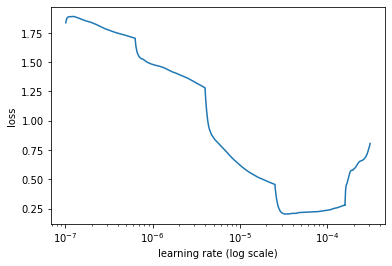

In [23]:
learner.lr_find(show_plot=True, max_epochs=10)

In [24]:
learner.fit_onecycle(3e-5, 5)



begin training using onecycle policy with max lr of 3e-05...
Epoch 1/5
1600/1600 [==============================] - 1894s 1s/step - loss: 0.8436 - accuracy: 0.7032 - val_loss: 0.2635 - val_accuracy: 0.9170
Epoch 2/5
1600/1600 [==============================] - 1879s 1s/step - loss: 0.1911 - accuracy: 0.9293 - val_loss: 0.1727 - val_accuracy: 0.9230
Epoch 3/5
1600/1600 [==============================] - 1879s 1s/step - loss: 0.1355 - accuracy: 0.9402 - val_loss: 0.1859 - val_accuracy: 0.9270
Epoch 4/5
1600/1600 [==============================] - 1879s 1s/step - loss: 0.0949 - accuracy: 0.9548 - val_loss: 0.1452 - val_accuracy: 0.9305
Epoch 5/5
1600/1600 [==============================] - 1878s 1s/step - loss: 0.0666 - accuracy: 0.9686 - val_loss: 0.1454 - val_accuracy: 0.9285


# Confusion Matrix

In [25]:
learner.validate(val_data=test_data, class_names=factors)

              precision    recall  f1-score   support

       anger       0.93      0.92      0.93       275
        fear       0.88      0.93      0.90       224
         joy       0.95      0.94      0.94       695
        love       0.79      0.82      0.80       159
     sadness       0.97      0.97      0.97       581
    surprise       0.84      0.71      0.77        66

    accuracy                           0.93      2000
   macro avg       0.89      0.88      0.89      2000
weighted avg       0.93      0.93      0.93      2000



array([[253,  10,   3,   0,   9,   0],
       [  7, 208,   0,   0,   5,   4],
       [  2,   0, 655,  33,   0,   5],
       [  0,   0,  29, 130,   0,   0],
       [  8,   4,   4,   1, 564,   0],
       [  2,  15,   1,   0,   1,  47]])

# Model testing and saving for future use

In [26]:
predictor = ktrain.get_predictor(learner.model, preproc=trans)

In [27]:
inp = 'I am very disappointed with this kind of front camera. Need refund.'

In [28]:
predictor.predict(inp)

'sadness'

In [35]:
predictor.save('drive/MyDrive/iMood_model')